# Предобработка временных рядов

На данном этапе мы познакомимся с алгоритмами предобработки временных рядов, которые часто используются как часть автоматических пайплайнов.

- Нерегулярные наблюдения
- Проблемы семплирования
- Заполнение пропусков
- Фильтрация рядов
- Устранение тренда и других компонент
- Lagged представление (как напоминание из тетрадки 1_time_series_exploration)


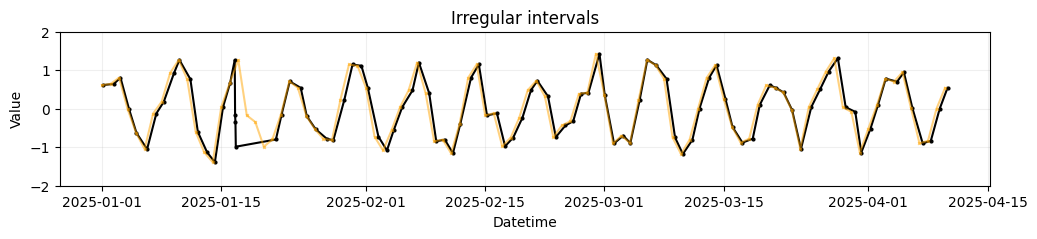

In [55]:
import random
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  

start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)
# Corrupt datetime indices a bit 
random_offsets = np.random.randint(1, 12, size=len(datetime_index))
random_offsets[16] = -10
random_offsets[17] = -9 - 24
random_offsets[18] = -8 - 48
random_offsets[19] = -7 - 72
datetime_irregular = datetime_index + pd.to_timedelta(random_offsets, unit='h')

t = np.arange(n)

noise_component_scale = 0.3
noise_values = np.random.normal(0, noise_component_scale, n)


def get_ts_with_season():
    # Let's simulate week seasonality
    m = 7
    values = np.sin(2 * np.pi * t / m) + noise_values
    return values 


def plot_ts_with_season(ts_with_season):
    fig_size = (12.0, 2.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(datetime_irregular, ts_with_season, marker="o", markersize=2, c="black")
    ax.plot(datetime_index, ts_with_season, marker="x", markersize=2, alpha=0.5, c="orange")
    ax.grid(alpha=0.2)
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Value")
    ax.set_ylim(-2, 2)
    ax.set_title("Irregular intervals")
    plt.show()


ts_with_season = get_ts_with_season()
plot_ts_with_season(ts_with_season)

In [56]:
df = pd.DataFrame({"datetime": datetime_irregular, "ts": ts_with_season})
df[15:21]

,datetime,ts
15,2025-01-16 01:00:00,0.669610
16,2025-01-16 14:00:00,1.264235
17,2025-01-16 15:00:00,-0.173462
18,2025-01-16 16:00:00,-0.345803
19,2025-01-16 17:00:00,-0.986583
20,2025-01-21 10:00:00,-0.799282


In [57]:
def resample_daily(df: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])

    df = df.set_index("datetime")

    df_resampled = df.resample("1D").agg(how)

    return df_resampled.reset_index()

resampled_df = resample_daily(df, "first")
resampled_df[15:21]

,datetime,ts
15,2025-01-16,0.669610
16,2025-01-17,NaN
17,2025-01-18,NaN
18,2025-01-19,NaN
19,2025-01-20,NaN
20,2025-01-21,-0.799282


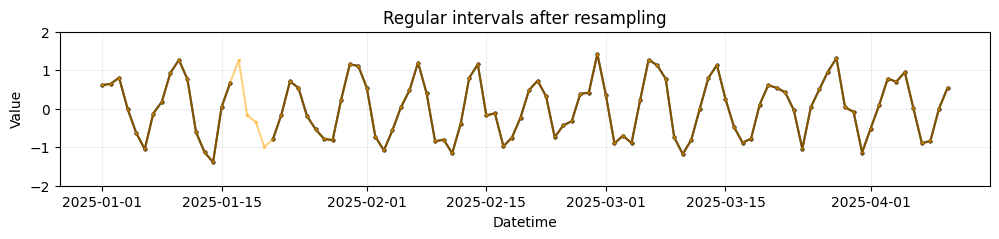

In [58]:
fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(resampled_df["datetime"], resampled_df["ts"], marker="o", markersize=2, c="black")
ax.plot(datetime_index, ts_with_season, marker="x", markersize=2, alpha=0.5, c="orange")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Regular intervals after resampling")
plt.show()

## Заполнение пропусков

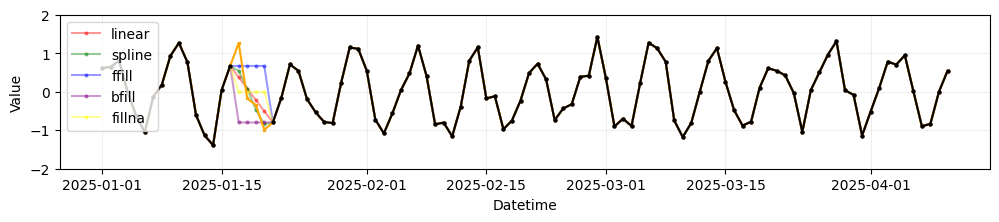

In [59]:
df_filled = resampled_df.copy()
df_filled["ts_linear"] = df_filled["ts"].interpolate(method="linear")
df_filled["ts_spline"] = df_filled["ts"].interpolate(method="cubicspline", order=4)
df_filled["ts_ffill"] = df_filled["ts"].ffill() 
df_filled["ts_bfill"] = df_filled["ts"].bfill() 
df_filled["ts_fillna"] = df_filled["ts"].fillna(0)

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(df_filled["datetime"], df_filled["ts_linear"], marker="o", markersize=2, alpha=0.4, c="red", zorder=1, label="linear")
ax.plot(df_filled["datetime"], df_filled["ts_spline"], marker="o", markersize=2, alpha=0.4, c="green", zorder=1, label="spline")
ax.plot(df_filled["datetime"], df_filled["ts_ffill"], marker="o", markersize=2, alpha=0.4, c="blue", zorder=1, label="ffill")
ax.plot(df_filled["datetime"], df_filled["ts_bfill"], marker="o", markersize=2, alpha=0.4, c="purple", zorder=1, label="bfill")
ax.plot(df_filled["datetime"], df_filled["ts_fillna"], marker="o", markersize=2, alpha=0.4, c="yellow", zorder=1, label="fillna")
ax.plot(df_filled["datetime"], df_filled["ts"], marker="o", markersize=2, c="black", zorder=2)
ax.plot(datetime_index, ts_with_season, marker="x", markersize=2, alpha=1, c="orange", zorder=1)
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

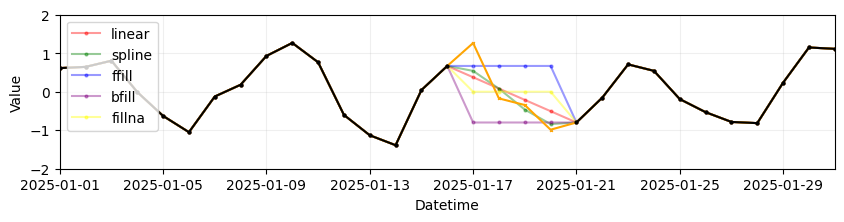

In [60]:
fig_size = (10.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(df_filled["datetime"], df_filled["ts_linear"], marker="o", markersize=2, alpha=0.4, c="red", zorder=1, label="linear")
ax.plot(df_filled["datetime"], df_filled["ts_spline"], marker="o", markersize=2, alpha=0.4, c="green", zorder=1, label="spline")
ax.plot(df_filled["datetime"], df_filled["ts_ffill"], marker="o", markersize=2, alpha=0.4, c="blue", zorder=1, label="ffill")
ax.plot(df_filled["datetime"], df_filled["ts_bfill"], marker="o", markersize=2, alpha=0.4, c="purple", zorder=1, label="bfill")
ax.plot(df_filled["datetime"], df_filled["ts_fillna"], marker="o", markersize=2, alpha=0.4, c="yellow", zorder=1, label="fillna")
ax.plot(df_filled["datetime"], df_filled["ts"], marker="o", markersize=2, c="black", zorder=2)
ax.plot(datetime_index, ts_with_season, marker="x", markersize=2, alpha=1, c="orange", zorder=1)
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
plt.xlim(df_filled["datetime"][0], df_filled["datetime"][30])
plt.legend(loc="upper left")
plt.show()

In [61]:
def fill_gaps_with_known_frequency(ts, f):
    x = np.asarray(ts, float)
    n = x.size
    t = np.arange(n)
    w = 2*np.pi*f

    m = ~np.isnan(x)
    X = np.c_[np.ones(m.sum()),             
              np.cos(w*t[m]),
              np.sin(w*t[m])]
    C, A, B = np.linalg.lstsq(X, x[m], rcond=None)[0]

    y_hat = C + A*np.cos(w*t) + B*np.sin(w*t)
    y_filled = x.copy()
    y_filled[~m] = y_hat[~m]                  

    return y_filled, y_hat

filled_ts, all_series = fill_gaps_with_known_frequency(df_filled["ts"].values, f=1/7)
df_filled["ts_filled_with_cos"] = filled_ts

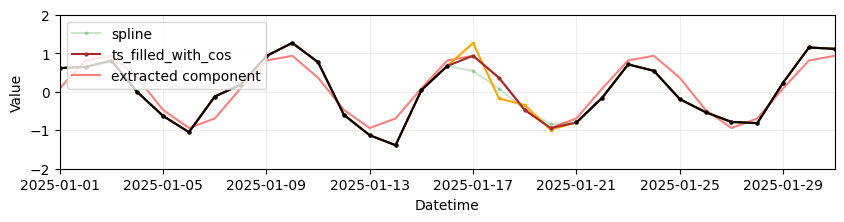

In [62]:
fig_size = (10.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(df_filled["datetime"], df_filled["ts_spline"], marker="o", markersize=2, alpha=0.2, c="green", zorder=1, label="spline")
ax.plot(df_filled["datetime"], df_filled["ts_filled_with_cos"], marker="o", markersize=2, alpha=1.0, c="brown", zorder=2, label="ts_filled_with_cos")
ax.plot(df_filled["datetime"], all_series, alpha=0.5, c="red", zorder=1, label="extracted component")
ax.plot(df_filled["datetime"], df_filled["ts"], marker="o", markersize=2, c="black", zorder=2)
ax.plot(datetime_index, ts_with_season, marker="x", markersize=2, alpha=1, c="orange", zorder=1)
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
plt.xlim(df_filled["datetime"][0], df_filled["datetime"][30])
plt.legend(loc="upper left")
plt.show()

Есть и более "экзотические" методы заполнения пропусков

<img src="../data/iterative_forecast.png" alt="Iterative forecast" width="500">

## Фильтрация

In [63]:
from ipywidgets import interact, FloatSlider, IntSlider


def _plot_moving_average(window_size=1):
    y = df_filled['ts_filled_with_cos'].rolling(window_size).mean()
    
    fig_size = (10.0, 2.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(df_filled["datetime"], y, marker="o", markersize=2, alpha=1, c="red",  zorder=2, label=f"window size {window_size}")
    ax.plot(df_filled["datetime"], df_filled["ts_filled_with_cos"], marker="o", markersize=2, alpha=0.5, c="black", 
            zorder=1, label="original ts")
    ax.grid(alpha=0.2)
    ax.set_ylim(-2, 2)
    plt.legend(loc="upper left")
    plt.show()

interact(
    _plot_moving_average,
    window_size=IntSlider(value=1, min=1, max=10, step=1, description="window_size")
);

interactive(children=(IntSlider(value=1, description='window_size', max=10, min=1), Output()), _dom_classes=('…

In [64]:
from scipy.ndimage import gaussian_filter

def _plot_sigma(sigma=1.0):
    y = gaussian_filter(np.array(df_filled['ts_filled_with_cos'], dtype=float), sigma=sigma)

    fig_size = (10.0, 2.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(df_filled["datetime"], y, marker="o", markersize=2, alpha=1, c="blue",  zorder=2, label=f"filtered (σ={sigma:.2f})")
    ax.plot(df_filled["datetime"], df_filled["ts_filled_with_cos"], marker="o", markersize=2, alpha=0.5, c="black", 
            zorder=1, label="original ts")
    ax.grid(alpha=0.2)
    ax.set_ylim(-2, 2)
    plt.legend(loc="upper left")
    plt.show()

interact(
    _plot_sigma,
    sigma=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description="sigma")
);

interactive(children=(FloatSlider(value=1.0, description='sigma', max=5.0, min=0.1), Output()), _dom_classes=(…

## Устранение нестационарности (тренда и других компонент)

Вычитание соседних элементов

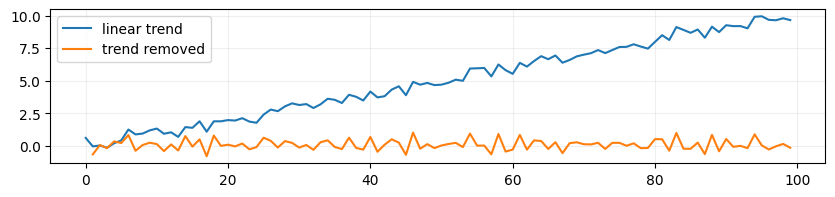

In [65]:
ts_with_linear_trend_up = 0.1 * t + noise_values

diffs = [np.nan]
diffs.extend(np.diff(ts_with_linear_trend_up))

fig_size = (10.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(ts_with_linear_trend_up, label="linear trend")
ax.plot(diffs, label="trend removed")
ax.grid(alpha=0.2)
plt.legend()
plt.show()

Логарифмирование

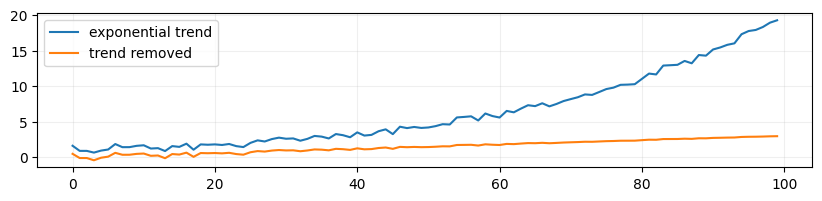

In [66]:
ts_with_exponential_trend = np.exp(0.03 * t) + noise_values
ts_with_exponential_trend_removed = np.log(ts_with_exponential_trend)

fig_size = (10.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)

ax.plot(ts_with_exponential_trend, label="exponential trend")
ax.plot(ts_with_exponential_trend_removed, label="trend removed")
ax.grid(alpha=0.2)
plt.legend()
plt.show()

Аппроксимация полиномом

In [67]:
ts_with_exponential_trend = np.exp(0.03 * t) + noise_values

def detrend_poly(x: np.ndarray, deg: int = 1):
    t = np.arange(x.size, dtype=float)
    c = np.polyfit(t, x, deg)
    trend = np.polyval(c, t)
    return x - trend, trend


def _plot(deg=1):
    y_detr, trend = detrend_poly(ts_with_exponential_trend, deg=deg)

    fig_size = (10.0, 4.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(ts_with_exponential_trend, label="exponential trend", alpha=0.8)
    ax.plot(trend, label=f"fitted component (degree={deg})")
    ax.plot(y_detr, label="trend removed")
    ax.grid(alpha=0.2)
    ax.set_ylim(-5, 25)
    ax.legend(loc="best")
    plt.show()

interact(
    _plot,
    deg=IntSlider(value=1, min=1, max=5, step=1, description="degree")
);

interactive(children=(IntSlider(value=1, description='degree', max=5, min=1), Output()), _dom_classes=('widget…

Пример исключения сезонности при помощи удаления низких частот

In [68]:
def detrend_fft_highpass(x: np.ndarray, cutoff_period: float, fs: float = 1.0) -> np.ndarray:
    x = np.asarray(x, float)
    n = x.size
    X = np.fft.rfft(x)                       
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fc = 1.0 / cutoff_period
    X[freqs < fc] = 0.0         
    y = np.fft.irfft(X, n=n)
    return y


def _plot(cutoff_period=15):
    y_detr = detrend_fft_highpass(ts_with_season, cutoff_period=cutoff_period)

    fig_size = (10.0, 4.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(ts_with_season, label="ts with season", alpha=0.8)
    ax.plot(y_detr, label=f"trend removed (cutoff_period={cutoff_period})")
    ax.plot(noise_values, label="noise", c='grey', alpha=0.3)
    ax.grid(alpha=0.2)
    ax.set_ylim(-3, 3)
    ax.legend(loc="best")
    plt.show()

interact(
    _plot,
    cutoff_period=IntSlider(value=15, min=1, max=15, step=1, description="cut period")
);

interactive(children=(IntSlider(value=15, description='cut period', max=15, min=1), Output()), _dom_classes=('…

Преобрзование Бокса-Кокса чтобы убрать нестационарность по дисперсии

In [69]:
from scipy import stats

trend = 0.1 * t
eps = np.random.normal(0, 2, n)
m = 7
# Amplitude of seasonal component increases over time
amplitude = np.linspace(0.5, 3.0, n)
seasonal_with_var = amplitude * np.sin(2 * np.pi * t / m)
ts_with_linear_trend_seasonality_and_variance = 2 + trend + seasonal_with_var + 0.1 * eps


def _plot(lmbda: float = 0.1):
    # Box Cox
    y = np.full_like(ts_with_linear_trend_seasonality_and_variance, np.nan)
    mask = ~np.isnan(ts_with_linear_trend_seasonality_and_variance)
    xp = ts_with_linear_trend_seasonality_and_variance[mask]
    min_x = xp.min()
    shift = 0.0 if min_x > 0 else -min_x + 1e-9
    y[mask] = stats.boxcox(xp + shift, lmbda=lmbda)

    y_detr, trend = detrend_poly(y, deg=1)
    
    fig_size = (10.0, 4.0)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(ts_with_linear_trend_seasonality_and_variance, label="exponential trend", alpha=0.8)
    ax.plot(y, label="variance non-stationarity removed")
    ax.plot(y_detr, alpha=0.2, label="time series without trend")
    ax.grid(alpha=0.2)
    ax.legend(loc="best")
    plt.ylim(-5, 25)
    plt.show()

interact(
    _plot,
    lmbda=FloatSlider(value=1.0, min=0.1, max=1.0, step=0.1, description="lmbda")
);

interactive(children=(FloatSlider(value=1.0, description='lmbda', max=1.0, min=0.1), Output()), _dom_classes=(…